In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import scipy

import os
from datetime import datetime
from datetime import timedelta
import glob
from skimage import io, filters

from tqdm import tqdm

from IPython.display import Image

from matplotlib import animation, rc
from IPython.display import HTML

from tqdm import tnrange, tqdm_notebook
from time import sleep

from scipy.optimize import curve_fit

In [2]:
#data_dir = '/Users/jmunroe/Insync/labdata'
data_dir = '/home/evankielley/research/wavetank/'

In [3]:
#dvpath = data_dir
dvpath = os.path.join(data_dir, 'dv')

In [4]:
dvfiles = ['dv_20161014154210','dv_20161014154241','dv_20161014154312',
            'dv_20161014154343','dv_20161014154413','dv_20161014154445',
            
            'dv_20161014154515','dv_20161014154546','dv_20161014155419',
            'dv_20161014155450','dv_20161014155521','dv_20161014155552',
            'dv_20161014155623','dv_20161014155654',
            
            'dv_20161014160132','dv_20161014160203','dv_20161014160234',
            'dv_20161014160305','dv_20161014160336','dv_20161014160407',
           ]

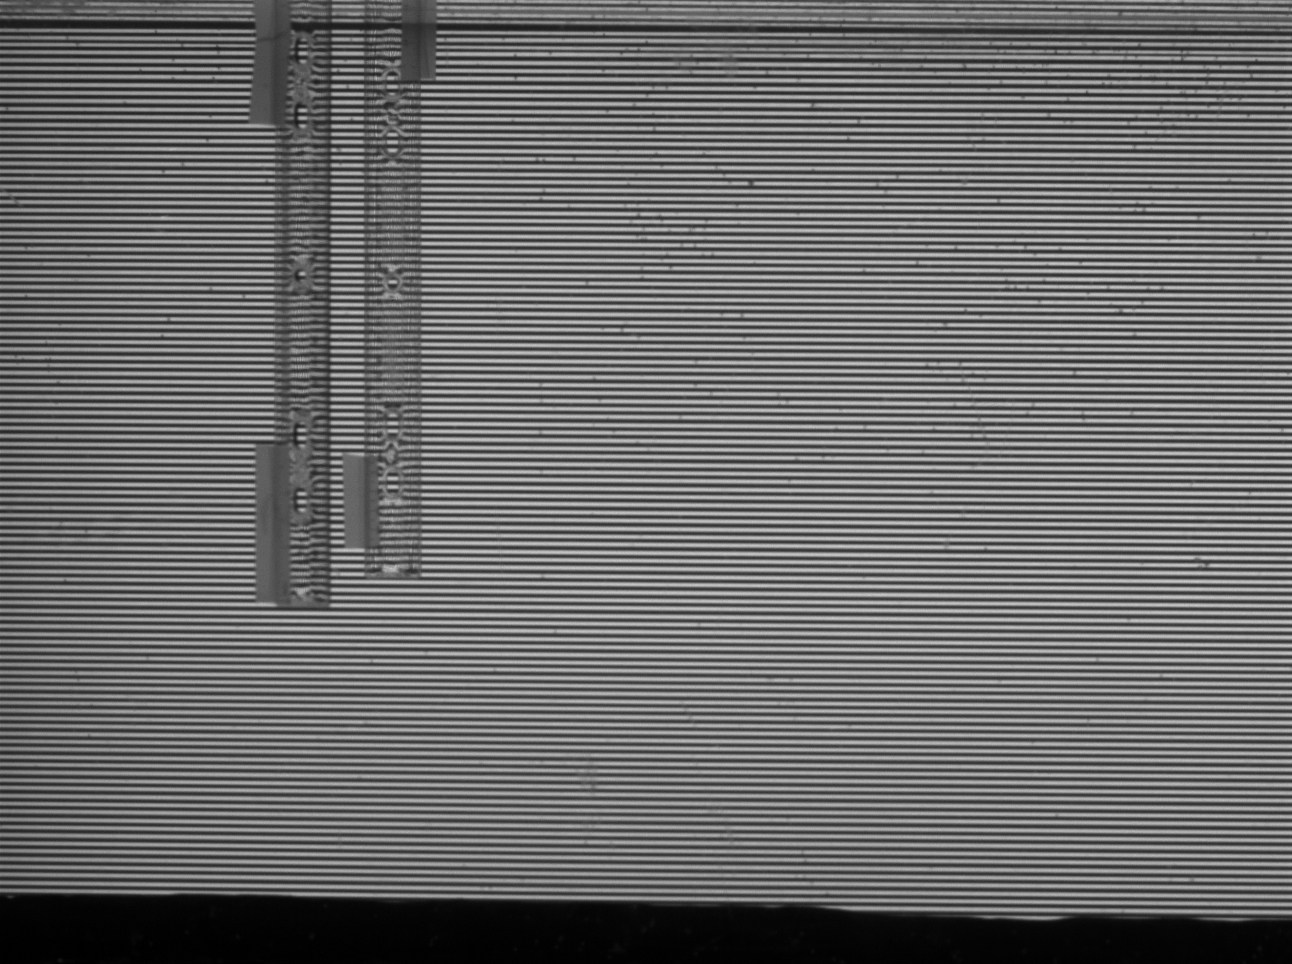

In [5]:
filename = os.path.join(dvpath, 'dv_20161014154210/1.jpg')
Image(filename, width=600)

In [6]:
images = []
times = []

# make a list of all frames available for analysis
for dvfile in dvfiles:
    dvfiledir = os.path.join(dvpath, dvfile)
    
    # find timestamp of bundle
    timestamp = dvfile.split('_')[1]
    timestamp = datetime.strptime(timestamp, '%Y%m%d%H%M%S')
    
    # get list of all image files
    imagefiles = glob.glob(os.path.join(dvfiledir,'*.jpg'))
    for imagefile in imagefiles:
        basename = os.path.basename(imagefile)
        n = int(basename.split('.')[0])
        dt = timedelta(seconds=(n-1)/10)
        t = timestamp + dt
        
        times.append(t)
        images.append(imagefile)
        
frames = pd.Series(images, index=times).reindex(index=sorted(times))

In [7]:
ts = frames.index[1]
ts.strftime('%H:%M:%S')

'15:42:10'

### Example pixel column

In [8]:
im0 = io.imread(frames[0])
im1 = io.imread(frames[720])  # reference image
im2 = io.imread(frames[750])  # current image

In [9]:
### Curve Fit ###

N = 8  # number of data points
t = np.linspace(0, 2*np.pi, N)  # number of periods
# initial parameter guesses
guess_freq = 0.86
guess_amplitude = 70
guess_phase = 0

# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

dz = np.zeros([40,40])

def coolfunc(im1,im2):

    for j in range (0,40):
        for i in np.arange(0,320,8):
            guess_offset = np.mean(im1[i:(i+8),j])
            p0=[guess_freq, guess_amplitude, guess_phase, guess_offset]
            fit = curve_fit(my_sin, t, im1[i:(i+8),j], p0=p0)
            a,b = fit
            freq_im1 = a[0]
            phase_im1 = a[2]

            guess_offset = np.mean(im2[i:(i+8),j])
            p0=[guess_freq, guess_amplitude, guess_phase, guess_offset]
            fit = curve_fit(my_sin, t, im2[i:(i+8),j], p0=p0)
            a,b = fit
            freq_im2 = a[0]
            phase_im2 = a[2]

            dz[(i/8),j] = (phase_im2 - phase_im1)/(0.5*(freq_im1 + freq_im2))
    return dz

In [10]:
def schlieren(frame1, frame2, window = None):
    
    image1 = io.imread(frame1)
    image1 = image1[100:800,100:800]
    image2 = io.imread(frame2)
    image2 = image2[100:800,100:800]

    
    if window is not None:
        image1 = image1[window]
        image2 = image2[window]
        
    dz = coolfunc(image1, image2)

    return dz

<IPython.core.display.Javascript object>


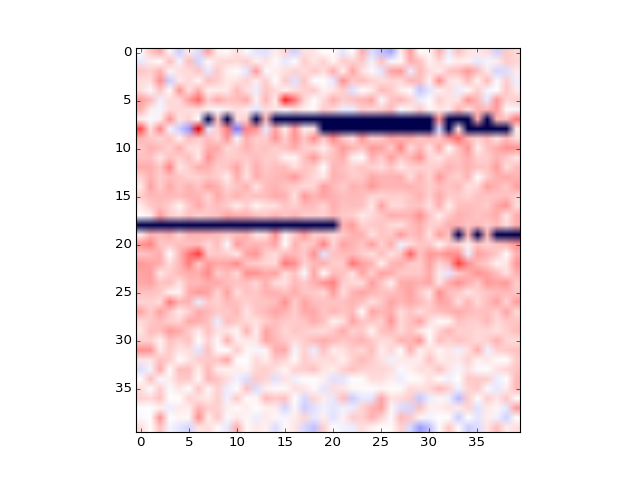

/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
n0 = 750
xmin, xmax = 0, 320
ymin, ymax = 0, 320

numframes = 10
pbar = tqdm_notebook(total=numframes, desc='Rendering', leave=True)

fig, ax = plt.subplots()
ax.invert_yaxis()
im = ax.imshow(dz, cmap=plt.get_cmap('seismic'), clim = [-1, 1])

# animation function. This is called sequentially
def animate(i):
    
    n = n0 + 5*i    
    dz = schlieren(frames[0], frames[n], window = (slice(ymin, ymax), slice(xmin, xmax)))
    im.set_array(dz)
    pbar.update()
    
    return (im)

# initialization function: plot the background of each frame
def init():
    im.set_array(im0)
    return (im)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, interval=1, blit=True)

anim.save('basic_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

#_ = anim.to_html5_video()

#pbar.close()
#plt.close(fig)

#anim